In [2]:
import matplotlib.pyplot as plt
from synutility.SynIO.data_type import load
from synutility.SynVis.graph_visualizer import GraphVisualizer

from src.functions import *
from src.invariants import weisfeiler_lehman_graph_hash, node_and_edge_label_histogram

In [3]:
# data = load('data/ITS_largerdataset.pkl.gz')
data = load('data/ITS_graphs.pkl.gz')

In [4]:
RID_KEY = 'R-id'  # used in small dataset
# RID_KEY = 'R_ID'  # used in big dataset

In [5]:
L_DEPTH = 0

In [6]:
reaction_centers = extract_reaction_centers(data, RID_KEY, L_DEPTH)

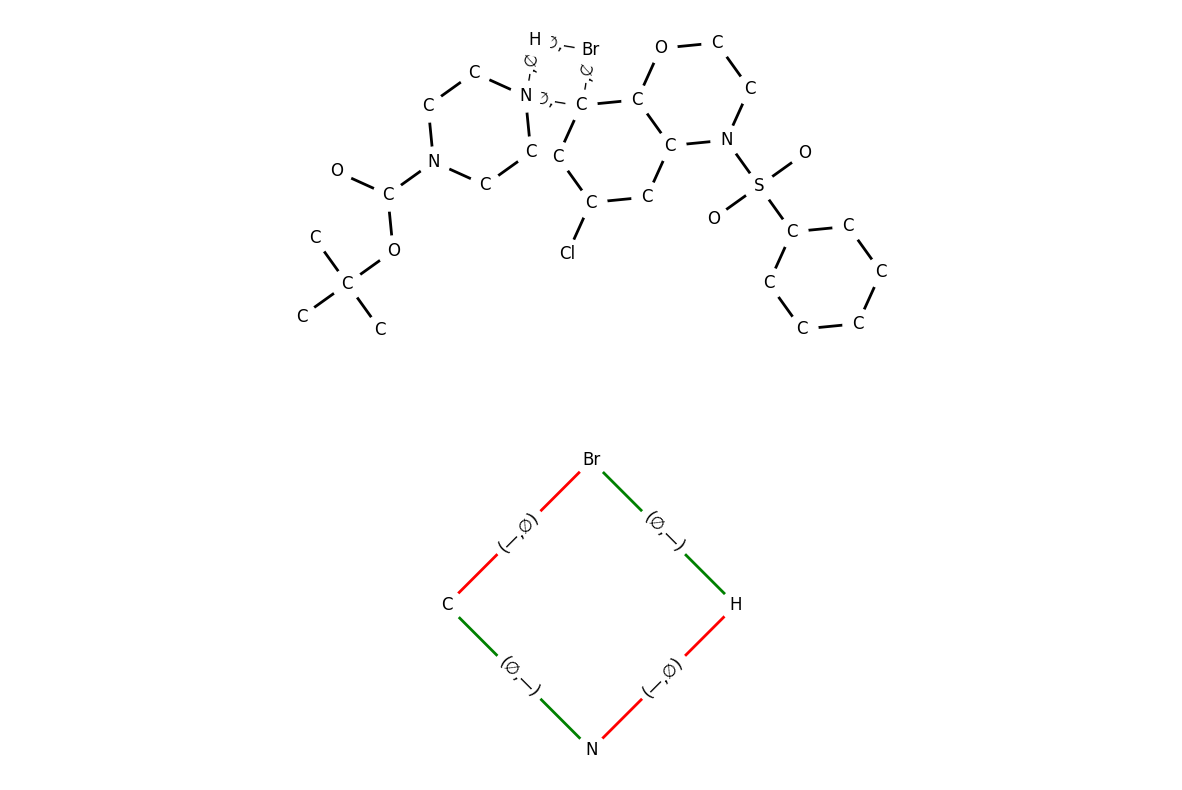

In [7]:
its_graph = data[0]['ITS']
reaction_center = reaction_centers[data[0][RID_KEY]]

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
vis = GraphVisualizer()

# Plot ITS graph and its reaction center
vis.plot_its(its_graph, ax[0], use_edge_color=True)
vis.plot_its(reaction_center, ax[1], use_edge_color=True)

# Display the plots
plt.show()

In [8]:
invariant_functions = {
    #    "vertex_count": vertex_count,
    #    "edge_count": edge_count,
    #    "vertex_degrees": vertex_degrees,
    #    "rank": rank,
    #    "algebraic_connectivity": algebraic_connectivity,
    "node_and_edge_label_histogram": node_and_edge_label_histogram,
    "weisfeiler_lehman_graph_hash_(1)": lambda G: weisfeiler_lehman_graph_hash(G, 1),
    "weisfeiler_lehman_graph_hash_(3)": lambda G: weisfeiler_lehman_graph_hash(G, 3),
}

In [9]:
G = next(iter(reaction_centers.values()))

In [10]:
histogram = []
for node, node_data in G.nodes(data=True):
    charge = node_data.get('charge', '')
    element = node_data.get('element', '')
    edge_labels = tuple(sorted(
        [edge_data.get('order', '') for _, _, edge_data in G.edges(node, data=True)]))
    histogram.append((charge, element, edge_labels))

In [11]:
invariant_values = calculate_invariant_values(reaction_centers, invariant_functions)

In [12]:
invariant_combinations_to_cluster = [[invariant] for invariant in invariant_functions.keys()]

In [13]:
invariant_clusters = cluster_by_invariant_combinations(invariant_values, invariant_combinations_to_cluster)

In [14]:
invariant_cluster_benchmark = benchmark_invariant_clusters(invariant_clusters)
invariant_cluster_benchmark

,execution_time_ms,num_clusters,num_clusters/ms,variance,variance*ms
node_and_edge_label_histogram,809.288263,288.0,0.355868,109492507.0,8.861100e+10
weisfeiler_lehman_graph_hash_(1),875.342846,296.0,0.338153,82559585.0,7.226794e+10
weisfeiler_lehman_graph_hash_(3),1918.303728,299.0,0.155867,82559161.0,1.583735e+11


In [15]:
invariant_combinations_to_isomorphism_check = invariant_combinations_to_cluster

In [16]:
isomorphism_clusters = cluster_invariant_clusters_by_isomorphism(reaction_centers, invariant_clusters)

In [17]:
isomorphism_cluster_benchmark = benchmark_isomorphism_clusters(isomorphism_clusters)
isomorphism_cluster_benchmark

,execution_time_ms,isomorphism_check_count,num_clusters
node_and_edge_label_histogram,3272.686005,40685.0,299.0
weisfeiler_lehman_graph_hash_(1),2699.556351,34108.0,299.0
weisfeiler_lehman_graph_hash_(3),2728.770733,34096.0,299.0
no_invariant,17274.295330,724002.0,299.0


In [18]:
final_benchmark = pd.concat(
    [invariant_cluster_benchmark.add_prefix("inva_"), isomorphism_cluster_benchmark.add_prefix("iso_")], axis=1
).drop(
    ["inva_num_clusters/ms", "inva_variance*ms"], axis=1
).rename(
    {
        "inva_execution_time_ms": "inva_ex_time",
        "iso_execution_time_ms": "iso_ex_time",
        "iso_isomorphism_check_count": "iso_check_count"
    }, axis=1
)

final_benchmark["total_ex_time"] = final_benchmark["inva_ex_time"].fillna(0) + final_benchmark["iso_ex_time"]

final_benchmark

,inva_ex_time,inva_num_clusters,inva_variance,iso_ex_time,iso_check_count,iso_num_clusters,total_ex_time
node_and_edge_label_histogram,809.288263,288.0,109492507.0,3272.686005,40685.0,299.0,4081.974268
weisfeiler_lehman_graph_hash_(1),875.342846,296.0,82559585.0,2699.556351,34108.0,299.0,3574.899197
weisfeiler_lehman_graph_hash_(3),1918.303728,299.0,82559161.0,2728.770733,34096.0,299.0,4647.074461
no_invariant,NaN,NaN,NaN,17274.295330,724002.0,299.0,17274.295330
